In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
data_path = "https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv"
training_df = pd.read_csv(filepath_or_buffer=data_path)

training_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


> We'll scale the `median_house_value`<br><br>

+ Scaling median_house_value puts the value of each house in units of thousands<br><br>
+ Scaling will keep loss values and learning rates in a friendlier range<br><br>
+ Although scaling a label is usually not essential, scaling features in a multi-feature model usually is essential<br><br>

In [3]:
training_df["median_house_value"] /= 1000.0
training_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66.9
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80.1
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85.7
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73.4
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65.5


In [4]:
training_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207.300912
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115.983764
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14.999000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119.400000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180.400000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500.001000


> #### Identifying anomalies in the dataset

+ The maximum value of several columns seems very high compared to the other quantiles. For example, example the `total_rooms column`<br><br>
+ Given the quantile values (25%, 50%, and 75%), you might expect the max value of `total_rooms` to be approximately 
5,000 or possibly 10,000. However, the max value is actually 37,937<br><br>
+ When you see anomalies in a column, become more careful about using that column as a feature<br><br>
+ That said, anomalies in potential features sometimes mirror anomalies in the label, which could make the column be (or seem to be) a powerful feature<br><br>
+ You might be able to represent (pre-process) raw data in order to make columns into useful features<br><br>

> ### Define functions that build and train a model

In [5]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
                
        self.linear = nn.Linear(in_features=1, out_features=1)

    def forward(self, x):
        return self.linear(x)

In [6]:
def build_model(my_learning_rate):
    model = LinearRegression()
    
    loss_fn = nn.MSELoss()
    optimizer = optim.RMSprop(model.parameters(), lr=my_learning_rate)
    
    return model, loss_fn, optimizer

In [15]:
def train_model(model, df, loss_fn, optimizer, feature, label, epochs, batch_size):
    
    train_loss_values = []
    
    feature_tensor = torch.tensor(df[feature].values,
                                  dtype=torch.float32).unsqueeze(dim=1)
    
    label_tensor = torch.tensor(df[label].values,
                                dtype=torch.float32).unsqueeze(dim=1)
    
    
    dataset = torch.utils.data.TensorDataset(feature_tensor, label_tensor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             shuffle=True)
    
    for epoch in range(epochs):
        train_epoch_loss = 0.0
        for batch_feature, batch_label in dataloader:
            model.train()
            train_preds = model(batch_feature)
            train_loss = loss_fn(train_preds, batch_label)
            train_epoch_loss += train_loss.item()
            optimizer.zero_grad()   
            train_loss.backward()   
            optimizer.step()
        train_loss_values.append(train_epoch_loss / len(dataloader))
        print(f"Epoch: {epoch} | Train Loss: {train_epoch_loss / len(dataloader)}")
    
    trained_weight = model.linear.weight.item()
    trained_bias = model.linear.bias.item()
    return trained_weight, trained_bias, train_loss_values

> We can experiment with different hyperparameters<br><br>

In [21]:
learning_rate = 0.01
epochs = 30
batch_size = 30

model, loss_fn, optimizer = build_model(learning_rate)

In [22]:
my_feature = "total_rooms"
my_label="median_house_value" 

tr_weight, tr_bias, train_loss_values = train_model(model, training_df, loss_fn,
                                                    optimizer, my_feature, my_label,
                                                    epochs, batch_size)

Epoch: 0 | Train Loss: 211209.02632326802
Epoch: 1 | Train Loss: 28436.998449900795
Epoch: 2 | Train Loss: 27924.55963231647
Epoch: 3 | Train Loss: 27009.726919022818
Epoch: 4 | Train Loss: 26417.309940613977
Epoch: 5 | Train Loss: 25960.47335637814
Epoch: 6 | Train Loss: 25088.389102458113
Epoch: 7 | Train Loss: 24393.92119726218
Epoch: 8 | Train Loss: 23853.696869488536
Epoch: 9 | Train Loss: 23406.818006296846
Epoch: 10 | Train Loss: 22447.40185288525
Epoch: 11 | Train Loss: 22050.37153638944
Epoch: 12 | Train Loss: 21411.926277281746
Epoch: 13 | Train Loss: 20966.674513182734
Epoch: 14 | Train Loss: 20422.08201015143
Epoch: 15 | Train Loss: 19962.608465608464
Epoch: 16 | Train Loss: 19807.674087336032
Epoch: 17 | Train Loss: 19159.984598042054
Epoch: 18 | Train Loss: 18553.240225763337
Epoch: 19 | Train Loss: 18406.299055472882
Epoch: 20 | Train Loss: 18023.268252418155
Epoch: 21 | Train Loss: 17588.051689780368
Epoch: 22 | Train Loss: 17269.52945446842
Epoch: 23 | Train Loss: 1692

In [24]:
def plot_the_model(trained_weight, trained_bias, feature, label):
    plt.xlabel(feature)
    plt.ylabel(label)
    
    random_examples = training_df.sample(n=200)
    plt.scatter(random_examples[feature], random_examples[label])
    
    x0 = 0
    y0 = trained_bias
    x1 = random_examples[feature].max()
    y1 = trained_bias + (trained_weight * x1)
    plt.plot([x0, x1], [y0, y1], c='r')

    plt.show()
    
def plot_the_loss_curve(epochs, mse):
    rmse = np.sqrt(mse)
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")

    plt.plot(epochs, rmse, label="Loss")
    plt.legend()
    plt.ylim([rmse.min()*0.97, rmse.max()])
    plt.show()

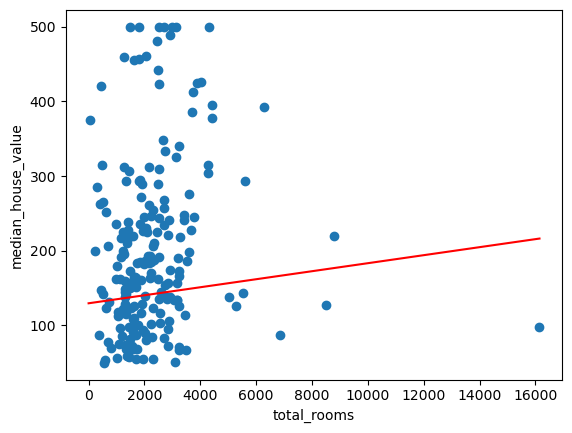

In [25]:
plot_the_model(tr_weight, tr_bias, my_feature, my_label)

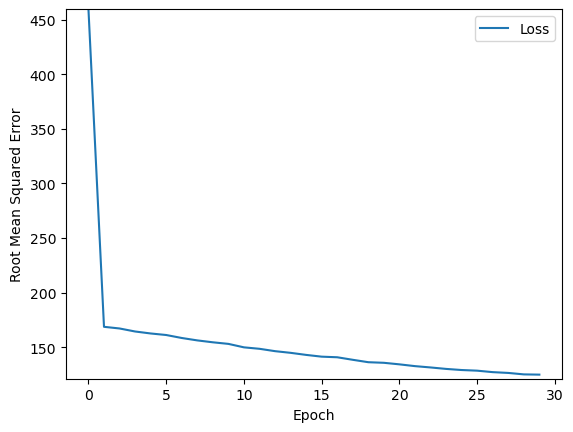

In [27]:
plot_the_loss_curve(range(epochs), np.array(train_loss_values))